## La Palma eruption figures and analysis

#### Figures
1. top down kriging map (hope to see plume) on la palma photogrammetry
2. distance from launch & altitude kriging map - add sample data
3. 3D plots on imagry map
4. Highlight good gaussian fit (fig 3) next to all data combined (fig 7) - in context of all of the data (all combined) - divide into days, maybe add color to elevation

In [1]:
%matplotlib inline
# %matplotlib notebook
import os, sys, math, datetime, time
import scipy.stats as stats
from scipy import optimize

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from dragonfly_util.mplogtocsv import parse_mplog
from dragonfly_util.logtocsv import parse_log
from dragonfly_util.ortho_map import OrthoMap
from dragonfly_util.plot_util import *
from dragonfly_util.reading import Reading
from sklearn.linear_model import LinearRegression

In [2]:
la_palma_map = OrthoMap([-18.058948516843866, -17.72935867309283], [28.537405559922902, 28.676808159899917], 'la_palma.png')
maps = [la_palma_map]

In [3]:
def read_data(file):
    return parse_log(file, skip_zeroing=False)

def filter_data(input, predicate):
    filtered = []
    for i in input:
        if predicate(i):
            filtered.append(i.data)
    return filtered

def between(start, end):
    start_date = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
    end_date = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
    return lambda value: value.type =='reading' and start_date <= value.date and end_date >= value.date and value.data.value > 0


df3_data = read_data("la_palma_data/la palma 11-28-2021 - df3.log")
df4_data = read_data("la_palma_data/la palma 11-29-2021 - df4.log")

transect_1km_a = filter_data(df4_data, between('2021-11-26 12:31:27.020316', '2021-11-26 12:35:06.006446'))
transect_1km_b = filter_data(df4_data, between('2021-11-26 12:35:06.006446', '2021-11-26 12:40:31.575184'))
lapalma_flight1 = transect_1km_a + transect_1km_b

lapalma_flight2a = filter_data(df4_data, between('2021-11-26 12:48:30.019876', '2021-11-26 12:53:59.006718'))
lapalma_flight2b = filter_data(df4_data, between('2021-11-26 12:53:59.006718', '2021-11-26 12:58:59.005814'))

lapalma_flight3 = filter_data(df4_data, between('2021-11-27 10:04:25.135506', '2021-11-27 10:13:39.120506'))

lapalma_flight4 = filter_data(df3_data, between('2021-11-27 13:15:02.982099', '2021-11-27 13:27:34.548221'))

lapalma_flight5 = filter_data(df3_data, between('2021-11-27 16:05:08.784123', '2021-11-27 16:24:0.942152'))

first_plume = filter_data(df3_data, between('2021-11-27 16:06:00.0', '2021-11-27 16:08:00.0'))
curtain_plume = filter_data(df3_data, between('2021-11-27 16:07:50.0', '2021-11-27 16:12:20.0'))
returning_plume = filter_data(df3_data, between('2021-11-27 16:14:30.0', '2021-11-27 16:16:30.0'))

lapalma_flight6 = filter_data(df3_data, between('2021-11-28 12:29:14.86601', '2021-11-28 12:45:21.740369'))

lapalma_flight8 = filter_data(df4_data, between('2021-11-29 10:58:22.295029', '2021-11-29 11:05:33.152931'))

flight_list = [lapalma_flight1, lapalma_flight2a, lapalma_flight2b, lapalma_flight3, lapalma_flight4, lapalma_flight5, first_plume, curtain_plume, returning_plume, lapalma_flight6, lapalma_flight8]
flight_labels = ['flight 1', 'flight 2a', 'flight 2b', 'flight 3', 'flight 4', 'flight 5', 'fligh 6a', 'flight 6b', 'flight 6c', 'flight 6', 'flight 8']


10003


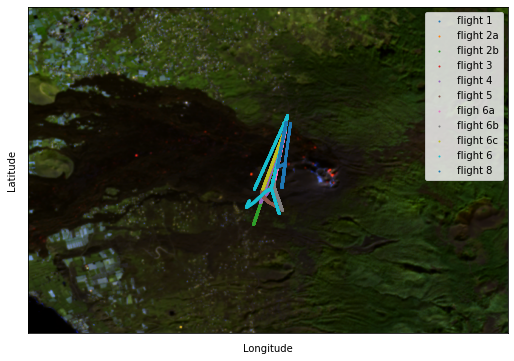

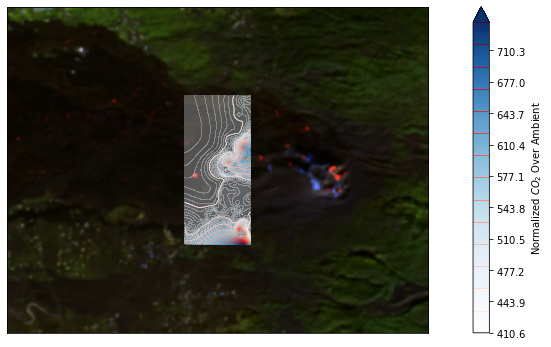

In [4]:
def display_lat_lon_datas(datas, names, ortho_maps, legend=True):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    max_lat = -360
    min_lat = 360
    max_lon = -360
    min_lon = 360
    earthCircumference = 40008000
    for i in range(len(datas)):
        data = datas[i]
        lat_data = []
        lon_data = []
        for d in data:
            lat_data.append(d.lat)
            lon_data.append(d.lon)
            max_lat = max(max_lat, d.lat)
            min_lat = min(min_lat, d.lat)
            max_lon = max(max_lon, d.lon)
            min_lon = min(min_lon, d.lon)
    
        ax.scatter(lon_data, lat_data, s=1, label=names[i])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    if legend:
        ax.legend()
    plot_maps(fig, ax, ortho_maps)
    
    dlat = max_lat - min_lat
    dlon = max_lon - min_lon
    lat_margin_scale = 1
    lon_margin_scale = 2
    minimum_size = 0.001

    dlat = max(max(dlat, dlon), minimum_size)
    dlon = max(dlat, dlon)

    ax.set_xlim(min_lon - (lon_margin_scale * dlon), max_lon + (lon_margin_scale * dlon))
    ax.set_ylim(min_lat - (lat_margin_scale * dlat), max_lat + (lat_margin_scale * dlat))

    geo_axis_format(ax)
    ax.plot()
    
def display_readings_krige2(name, readings, ortho_maps, nlags=6, minco2=None, maxco2=None, addons=None):
    fig, ax = plt.subplots(figsize=(16, 6))

    plot_maps(fig, ax, ortho_maps)

    plot_krige(name, fig, ax, [r.lon for r in readings], [r.lat for r in readings], [r.value for r in readings], nlags, minco2, maxco2)

    zoom_to_data(ax, readings)
    geo_axis_format(ax)

    if addons is not None:
        addons(plt, fig, ax)

    ax.plot()
    
display_lat_lon_datas(flight_list, flight_labels, maps)
plt.savefig("lat_lon_datas.pdf", format="pdf")

combined_data = [item for sublist in flight_list for item in sublist if item.value > 430]

print(len(combined_data))

display_readings_krige2('la palma top3', combined_data, maps)
plt.savefig("lat_lon_krig.pdf", format="pdf")

/home/john/dev/lapalma-expedition/dragonfly_util/plot_util.py:191: UserWarning: Trying to register the cmap 'reds_alpha' which already exists.
  plt.register_cmap(cmap=reds_map_object)
/home/john/dev/lapalma-expedition/dragonfly_util/plot_util.py:193: UserWarning: Trying to register the cmap 'blues_alpha' which already exists.
  plt.register_cmap(cmap=blues_map_object)


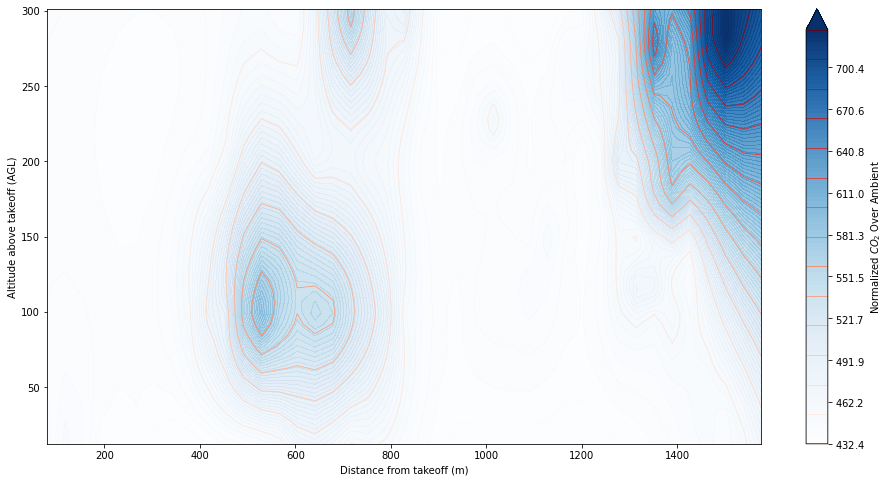

In [5]:
def display_altitude_distance_krig(name, starting_position, readings, nlags=6, minco2=None, maxco2=None, addons=None):
    fig, ax = plt.subplots(figsize=(16, 8))
    
    earthCircumference = 40008000
    distance_data = []
    co2 = []
    altitude = []
    
    for i in range(len(readings)):
        d = readings[i]
        lat_diff = (starting_position.lat - d.lat) * (earthCircumference / 360) * math.cos(starting_position.lat * 0.01745)
        lon_diff = (starting_position.lon - d.lon) * (earthCircumference / 360)
        distance = math.sqrt((lat_diff*lat_diff) + (lon_diff*lon_diff))
        distance_data.append(distance)
        altitude.append(d.alt - starting_position.alt)
        co2.append(float(d.value))

    plot_krige(name, fig, ax, distance_data, altitude, co2, nlags, minco2, maxco2)

#     zoom_to_data(ax, readings)
#     geo_axis_format(ax)
    if addons is not None:
        addons(plt, fig, ax)

    ax.set_xlabel('Distance from takeoff (m)')
    ax.set_ylabel('Altitude above takeoff (AGL)')
    ax.plot()

minco2 = min([reading.value for reading in combined_data])
maxco2 = max([reading.value for reading in combined_data]) / 1.6

display_altitude_distance_krig('lapalma_combined', lapalma_flight1[0], combined_data)
plt.savefig("altitude_krig.pdf", format="pdf")